#### Copyright © 2023 Taeyoung Kim and Mingi Kang. All rights reserved. ####

This is the solution for the homework assignment of the Machine Learning and Optimization lecture for WS2023. 

In [1]:
# necessary libraries
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [2]:
X = np.loadtxt('hitters.x.csv', delimiter=',', skiprows=1)
with open('hitters.x.csv', 'r') as f:
    X_colnames = next(csv.reader(f))

y = np.loadtxt('hitters.y.csv', delimiter=',', skiprows=1)


In [3]:
X -= X.mean(0)[None, :]
X /= X.std(0)[None, :]

### Problem 3-1. 

1. Scaling ensures that all features have equal weights and prevents any one feature from overpowering the others.
2. Scaling features makes the interpretation of alpha more straightforward.
3. Large variations in feature values can lead to numerical instabilities, 
   * especially when using gradient-based optimization algorithms. 
   * Standardizing the features helps mitigate this issue.
4. When the features are scaled, the coefficients of the ridge regression model can be interpreted more easily.

In [4]:
# Scale X
scaler = StandardScaler()
X = scaler.fit_transform(X)

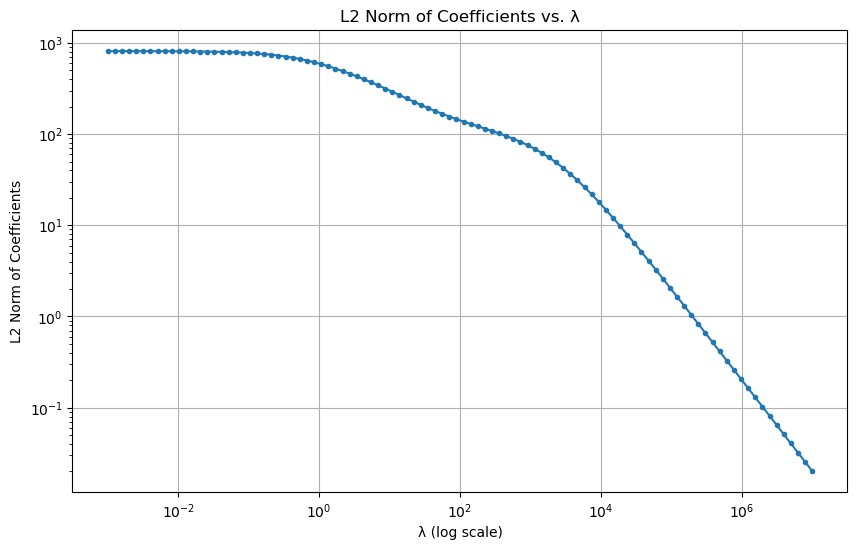

In [8]:
#Problem 3-3. 

lambdas = np.logspace(-3, 7, 100)
l2_norms = []

for alpha in lambdas:
    ridge = Ridge(alpha=alpha, fit_intercept=True, solver='auto')
    ridge.fit(X, y)
    
    coefficients = ridge.coef_
    
    l2_norm = np.linalg.norm(coefficients[1:])
    
    l2_norms.append(l2_norm)

plt.figure(figsize=(10, 6))
plt.loglog(lambdas, l2_norms, marker='.')
plt.title('L2 Norm of Coefficients vs. λ')
plt.xlabel('λ (log scale)')
plt.ylabel('L2 Norm of Coefficients')
plt.grid()
plt.show()

In [9]:
#Problem 3-4. 

lambda_small = 1e-6  
lambda_large = 1e6

ridge_small = Ridge(alpha=lambda_small, fit_intercept=True)
ridge_small.fit(X, y)

ridge_large = Ridge(alpha=lambda_large, fit_intercept=True)
ridge_large.fit(X, y)

least_squares = Ridge(alpha=0, fit_intercept=True)
least_squares.fit(X, y)

coeff_small_lambda = ridge_small.coef_
coeff_large_lambda = ridge_large.coef_
coeff_least_squares = least_squares.coef_

print("Coefficients for Small Lambda:")
print(coeff_small_lambda)

print("\nCoefficients for Large Lambda:")
print(coeff_large_lambda)

print("\nCoefficients for Least Squares:")
print(coeff_least_squares)

Coefficients for Small Lambda:
[-291.0946081   337.83051492   37.85380731  -60.57247659  -26.99493205
  135.0739315   -16.69333264 -391.03844949   86.68732831  -14.18175469
  480.74740261  260.6898459  -213.89239438   31.24874959  -58.41399662
   78.76122933   53.73243352  -22.16080499  -12.34883348]

Coefficients for Large Lambda:
[ 0.04666088  0.05186084  0.04053656  0.04963197  0.05312474  0.05247341
  0.0473423   0.06218041  0.06487681  0.06204106  0.06650412  0.06701109
  0.05788527 -0.00167336 -0.02278176  0.03554373  0.00300839 -0.00064142
 -0.00032317]

Coefficients for Least Squares:
[-291.09462584  337.83057573   37.85384355  -60.57253276  -26.99496538
  135.07394623  -16.69329665 -391.03867469   86.68713265  -14.18188514
  480.74772158  260.69007975 -213.8924465    31.24874897  -58.41399362
   78.76122932   53.73244107  -22.16080176  -12.34882979]


In [10]:

X_aug = np.hstack((np.ones((X.shape[0], 1)), X))

def ridge(X_aug, y, lamda):
    eye_aug = np.eye(X_aug.shape[1])
    eye_aug[0, 0] = 0
    return np.linalg.inv(X_aug.T @ X_aug + lamda * eye_aug) @ (X_aug.T @ y)

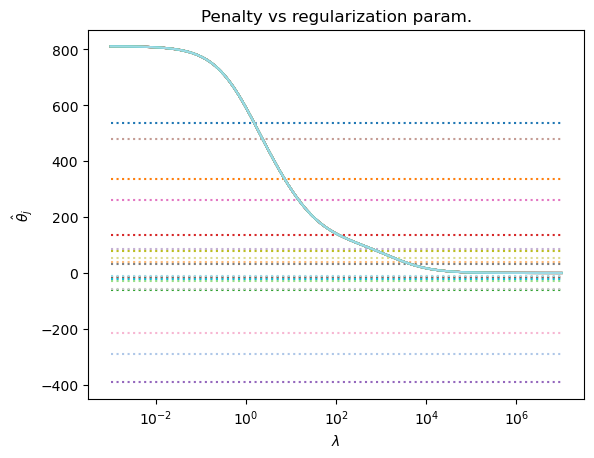

In [11]:
theta_mse = ridge(X_aug, y, 0)

for j, theta in enumerate(theta_mse):
    plt.semilogx(lambdas, np.ones_like(lambdas) * theta, ':', c=plt.cm.tab20(j/20))
    plt.semilogx(lambdas, l2_norms, c=plt.cm.tab20(j/20))

plt.title('Penalty vs regularization param.')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\hat{\theta}_j$')
plt.show()

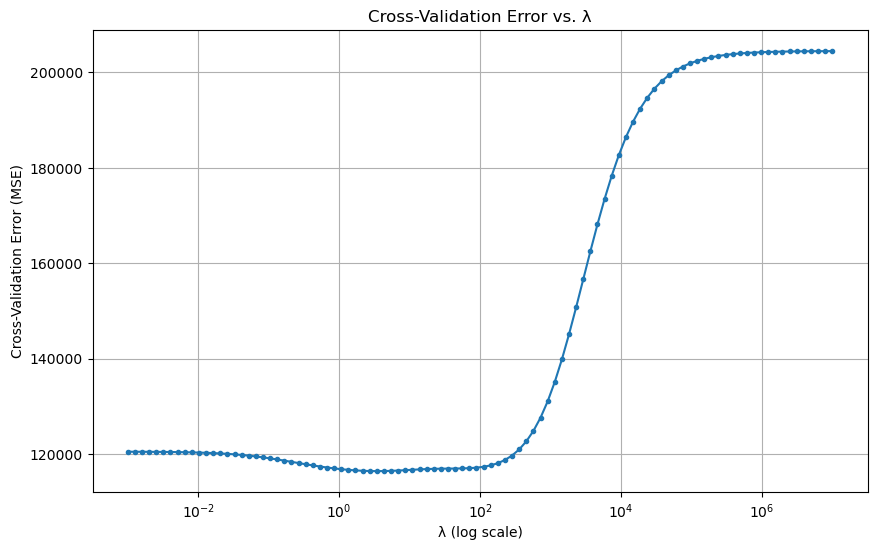

Best λ: 3.4304692863149193


In [13]:
#Problem 3-5. 

from sklearn.model_selection import KFold

lambdas = np.logspace(-3, 7, 100)

cross_val_errors = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for alpha in lambdas:
    errors = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        ridge = Ridge(alpha=alpha, fit_intercept=True)
        ridge.fit(X_train, y_train)
        
        y_val_pred = ridge.predict(X_val)
        mse = np.mean((y_val - y_val_pred) ** 2)
        errors.append(mse)
    
    avg_error = np.mean(errors)
    cross_val_errors.append(avg_error)

plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, cross_val_errors, marker='.')
plt.title('Cross-Validation Error vs. λ')
plt.xlabel('λ (log scale)')
plt.ylabel('Cross-Validation Error (MSE)')
plt.grid()
plt.show()

best_lambda = lambdas[np.argmin(cross_val_errors)]
print("Best λ:", best_lambda)

In [14]:
#Problem 3-6. 


X_aug = np.hstack((np.ones((X.shape[0], 1)), X))

def ridge(X_aug, y, lamda):
    eye_aug = np.eye(X_aug.shape[1])
    eye_aug[0, 0] = 0
    return np.linalg.inv(X_aug.T @ X_aug + lamda * eye_aug) @ (X_aug.T @ y)

best_theta = ridge(X_aug, y, best_lambda)


print("Coefficient Estimates at Best Lambda: \n")
for i, feature_name in sorted(enumerate(['bias'] + X_colnames), key=lambda x: best_theta[x[0]]):
    print('%s: %g' % (feature_name, best_theta[i]))

Coefficient Estimates at Best Lambda: 

AtBat: -216.714
CWalks: -146.358
CAtBat: -96.0925
DivisionW: -61.722
Years: -51.3809
Errors: -25.1134
NewLeagueN: -13.6032
Runs: -0.579298
HmRun: 1.92036
RBI: 4.76303
LeagueN: 30.2702
Assists: 39.2803
CHmRun: 57.8787
PutOuts: 77.6081
Walks: 107.086
CRBI: 115.498
CHits: 120.702
CRuns: 201.464
Hits: 232.248
bias: 535.926
